<a href="https://colab.research.google.com/github/danglive/prediction-energy-consumption/blob/master/Prediction_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import the libraries
import pandas as pd

In [0]:
# load dataset
url = 'https://raw.githubusercontent.com/danglive/prediction-energy-consumption/master/EnergyConsumptionEstimation.csv'
dataset = pd.read_csv(url, error_bad_lines=False, parse_dates=True, index_col='timestamp')

In [23]:
# Info of dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4407 entries, timestamp to 2018-05-25 12:00:00
Data columns (total 5 columns):
Delivered_Energy          4407 non-null object
Travelled_Distance        4407 non-null object
Temperature_Exterieure    4407 non-null object
DriverBehaviour           4407 non-null object
DriverSex                 4407 non-null object
dtypes: object(5)
memory usage: 206.6+ KB


In [24]:
# Drop line 1 
dataset = dataset.iloc[1:]
dataset.head(5)

,Delivered_Energy,Travelled_Distance,Temperature_Exterieure,DriverBehaviour,DriverSex
timestamp,,,,,
2017-11-22 23:00:00,9.05700081620839,8.738133146835025e-06,11.3,0.2171607905520091,female
2017-11-23 00:00:00,9.05700081620839,0.0,11.2,0.24535736823806864,male
2017-11-23 01:00:00,9.05700081620839,8.738133146835025e-06,10.8,0.06334444369720382,female
2017-11-23 02:00:00,9.05700081620839,0.0,11.3,0.9304906366876564,male
2017-11-23 03:00:00,9.05700081620839,8.738133146835025e-06,11.7,0.032536781573978324,male


In [25]:
# Selecting the feature
feature = ['Delivered_Energy','Travelled_Distance','DriverBehaviour','DriverSex']
dataset = dataset[feature]
dataset.head(4)

,Delivered_Energy,Travelled_Distance,DriverBehaviour,DriverSex
timestamp,,,,
2017-11-22 23:00:00,9.05700081620839,8.738133146835025e-06,0.2171607905520091,female
2017-11-23 00:00:00,9.05700081620839,0.0,0.24535736823806864,male
2017-11-23 01:00:00,9.05700081620839,8.738133146835025e-06,0.06334444369720382,female
2017-11-23 02:00:00,9.05700081620839,0.0,0.9304906366876564,male


In [0]:
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from pandas import concat
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error

In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [0]:
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,3] = encoder.fit_transform(values[:,3])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [29]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)     var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1   0.347495  4.382665e-07   0.217037        0.0  0.347495
2   0.347495  0.000000e+00   0.245243        1.0  0.347495
3   0.347495  4.382665e-07   0.063169        0.0  0.347495
4   0.347495  0.000000e+00   0.930607        1.0  0.347495
5   0.347495  4.382665e-07   0.032351        1.0  0.347495


In [30]:
n_sample = reframed.shape[0]
n_sample

4405

In [31]:
# split into train and test sets
values = reframed.values
# Using 60% for train and 40% for test
n_train_hours = int(n_sample*0.6)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2643, 1, 4) (2643,) (1762, 1, 4) (1762,)


In [32]:
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
train_X.shape, train_y.shape

((2643, 4), (2643,))

In [0]:
# Scikit-Learn Machine Learning models
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from timeit import default_timer as timer

In [0]:
def rmse(prediction,test_y):
  # Calculate the rmse
  yhat = np.reshape(prediction, (len(prediction),-1)) 
  
  # invert scaling for forecast
  inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
  inv_yhat = scaler.inverse_transform(inv_yhat)
  inv_yhat = inv_yhat[:,0]
  # invert scaling for actual
  test_y = test_y.reshape((len(test_y), 1))
  inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
  inv_y = scaler.inverse_transform(inv_y)
  inv_y = inv_y[:,0]
  # calculate RMSE
  rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
  return rmse, inv_y, inv_yhat

In [0]:
# Timing utilities
def implement_model(model, train_X, train_y, test_X, test_y, model_name):
         
    train_start = timer()
    
    # Start the timer
    train_start = timer()

    # Train the model
    model.fit(train_X, train_y)

    # Calculate training time
    train_end = timer()
    train_time = train_end - train_start

    # Start test timer
    test_start = timer()

    # Make predictions
    predictions = model.predict(test_X)

    # Calculate testing time
    test_end = timer()
    test_time = test_end - test_start

    # Calculate the rmse
    rmse_model,_,_ = rmse(predictions,test_y)

    # Record the results
    results = [model_name, train_time, test_time,rmse_model]
    
    return results

In [0]:
def evaluate_models(train_X, train_y, test_X, test_y):
  
  # LinearRegression
  model = LinearRegression()
  LR_results =  implement_model(model, train_X, train_y, test_X, test_y, model_name = 'LinearRegression')

  # LinearRegression regulization
  model = Lasso(alpha=0.1)
  Lasso_results =  implement_model(model, train_X, train_y, test_X, test_y, model_name = 'Lasso')

  # knn
  model = KNeighborsRegressor()
  knn_results = implement_model(model, train_X, train_y, test_X, test_y, model_name = 'knn')

  # svm
  model = SVR()
  svm_results = implement_model(model, train_X, train_y, test_X, test_y, model_name = 'svm')
    
  # rf
  model = RandomForestRegressor(n_estimators = 10, random_state = 42, n_jobs = -1)
  rf_results = implement_model(model, train_X, train_y, test_X, test_y, model_name = 'rf')
    
   
  # adaboost
  model = AdaBoostRegressor(n_estimators = 10, learning_rate = 0.001, loss = 'exponential')
  adaboost_results = implement_model(model,train_X, train_y, test_X, test_y, model_name = 'adaboost')

  # Gradient Boots
  model = GradientBoostingRegressor(loss='quantile', alpha=0.9, n_estimators=10, max_depth=3, learning_rate=.1)
  GradientBoosting_results = implement_model(model,train_X, train_y, test_X, test_y, model_name = 'Gradientboost')

  # MLP
  model = MLPRegressor(learning_rate='adaptive', max_iter=5000, hidden_layer_sizes=(50, 100, 2))
  MLP_results = implement_model(model,train_X, train_y, test_X, test_y, model_name = 'MLP')

  # Put the results into a single array (stack the rows)
  results = np.vstack((LR_results, Lasso_results, knn_results, svm_results, rf_results, adaboost_results, GradientBoosting_results, MLP_results))
  
  # Convert the results to a dataframe
  results = pd.DataFrame(results, columns = ['model', 'train time', 'test time', 'rmse'])
    
  # Convert the numeric results to numbers
  results.iloc[:, 1:] = results.iloc[:, 1:].astype(np.float32)

    
  return results

In [37]:
results = evaluate_models(train_X, train_y, test_X, test_y)
results

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


,model,train time,test time,rmse
0,LinearRegression,0.00178857,0.000306135,2.43199
1,Lasso,0.00313582,0.000285583,7.49519
2,knn,0.00352318,0.0222098,2.76406
3,svm,0.0716872,0.0155396,2.83093
4,rf,0.106245,0.102451,2.29734
5,adaboost,0.0330659,0.00156571,2.8232
6,Gradientboost,0.019761,0.000455438,8.97394
7,MLP,0.507364,0.00534776,2.30407


From these results, it appears the random forest significantly outperform the competition.

In [38]:
rmse_best = results['rmse'].min()
print('The best root mean square error', rmse_best)

The best root mean square error 2.2973406314849854


**Hyperparameter Tuning the Random Forest**




**Using random search**

In [39]:
# To look at the available hyperparameters, creating a random forest and examine the default values.
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [40]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [41]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_X, train_y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.0min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [42]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 100}

In [43]:
prediction_best=rf_random.best_estimator_.predict(test_X)
random_best, test_random, pred_random = rmse(prediction_best,test_y)
random_best

2.2869320622972524

In [44]:
print('Improvement of {:0.2f}%.'.format( 100 * (rmse_best - random_best) / rmse_best))

Improvement of 0.45%.


We achieved an unspectacular improvement in accuracy of 0.14%.

In [0]:
# Define training time and tesing time
timestamp = dataset.index
timestamp_train = timestamp[:n_train_hours]
timestamp_test = timestamp[1+n_train_hours:]
# creating a dataframe with the combination of both predictions, and appending the right datetimeindex
Random_Pred = pd.DataFrame({'Delivered Energy':  test_random, 'Prediction': pred_random}, index=timestamp_test)

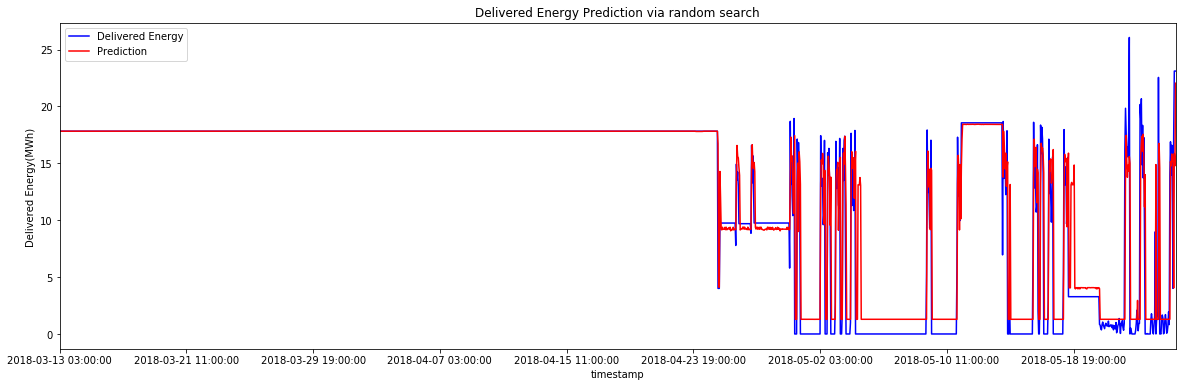

In [80]:
# Visualize
import matplotlib.pylab as plt
Random_Pred.plot(figsize=(20, 6), color=('b', 'r'))
plt.ylabel('Delivered Energy(MWh) ')
plt.title('Delivered Energy Prediction via random search')
plt.show()

In [75]:
# Checking the accuracy of model prediction using grid search
mape = 100 * np.mean(abs(test_random - pred_random))/np.mean(abs(test_random))
accuracy = 100 - mape
print('Accuracy = {:0.2f}%.'.format(accuracy))

Accuracy = 93.97%.


**Using the Grid  Search**

In [0]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [40, 50, 60],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [400, 600, 800]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, verbose = 2, n_jobs = -1)

In [58]:
# Fit the grid search to the data
grid_search.fit(train_X, train_y)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 17.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth':

In [59]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 400}

In [60]:
best_grid = grid_search.best_estimator_.predict(test_X)
grid_best, grid_test, grid_pred = rmse(best_grid,test_y)
grid_best

2.295007768303637

In [61]:
print('Improvement of {:0.2f}%.'.format(100*(rmse_best - grid_best)/rmse_best))

Improvement of 0.10%.


In [0]:
# creating a dataframe with the combination of both predictions, and appending the right datetimeindex
Random_Pred = pd.DataFrame({'Delivered Energy':  grid_test, 'Prediction': grid_pred}, index=timestamp_test)

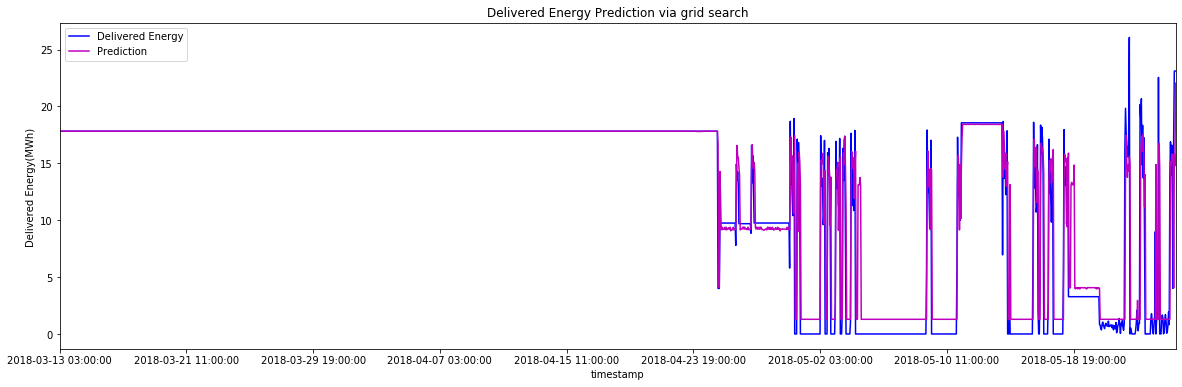

In [79]:
# Visualize
import matplotlib.pylab as plt
Random_Pred.plot(figsize=(20, 6), color=('b', 'm'))
plt.ylabel('Delivered Energy(MWh) ')
plt.title('Delivered Energy Prediction via grid search')
plt.show()

In [76]:
# Checking the accuracy of model prediction using grid search
mape = 100 * np.mean(abs(grid_test - grid_pred))/np.mean(abs(grid_test))
accuracy = 100 - mape
print('Accuracy = {:0.2f}%.'.format(accuracy))

Accuracy = 93.94%.


**Discussion**

+ The random forest model performed well for Delivered energy prediction which is better than other models (SVM, kNN,...)

+ Using grid search improved 0.1% accuracy and random search improved 0.14%

+ Can improve the better for hyperparameter tuning by using Bayesian optimization

+ Try with Deep Learining algorihtme with LSTM